In [1]:
import re
import os
import string

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import gensim

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.initializers import Constant

%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset = pd.read_json('dataset/financialData.json')
dataset.drop(dataset[(dataset.sentiment >= -0.1) & (dataset.sentiment <= 0.1)].index, inplace=True)

In [3]:
len(dataset)

2583

In [4]:
X = np.array(dataset['title'])
y = np.asarray([1 if s >= 0 else 0 for s in dataset['sentiment']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
tokenizer_obj =  Tokenizer()

tokenizer_obj.fit_on_texts(dataset['title'])

max_length = max([len(s.split()) for s in dataset['title']])

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [6]:
 EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=25, verbose=2, validation_data=(X_test_pad, y_test))

Train on 2066 samples, validate on 517 samples
Epoch 1/25
 - 1s - loss: 0.0214 - accuracy: 0.9918 - val_loss: 0.8305 - val_accuracy: 0.7756
Epoch 2/25
 - 1s - loss: 0.0221 - accuracy: 0.9913 - val_loss: 0.7503 - val_accuracy: 0.7795
Epoch 3/25
 - 1s - loss: 0.0254 - accuracy: 0.9908 - val_loss: 0.9637 - val_accuracy: 0.7737
Epoch 4/25
 - 1s - loss: 0.0229 - accuracy: 0.9913 - val_loss: 0.8942 - val_accuracy: 0.7679
Epoch 5/25
 - 1s - loss: 0.0245 - accuracy: 0.9908 - val_loss: 0.6961 - val_accuracy: 0.7776
Epoch 6/25
 - 1s - loss: 0.0406 - accuracy: 0.9913 - val_loss: 1.0750 - val_accuracy: 0.7756
Epoch 7/25
 - 1s - loss: 0.0413 - accuracy: 0.9903 - val_loss: 0.9879 - val_accuracy: 0.7679
Epoch 8/25
 - 1s - loss: 0.0417 - accuracy: 0.9923 - val_loss: 0.8902 - val_accuracy: 0.7698
Epoch 9/25
 - 1s - loss: 0.0386 - accuracy: 0.9908 - val_loss: 0.9010 - val_accuracy: 0.7621
Epoch 10/25
 - 1s - loss: 0.0300 - accuracy: 0.9918 - val_loss: 0.7472 - val_accuracy: 0.7640
Epoch 11/25
 - 1s - lo

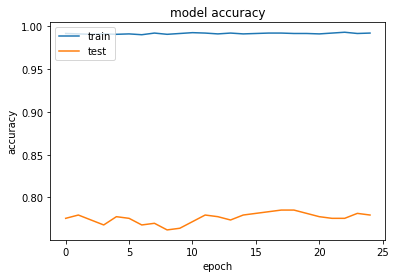

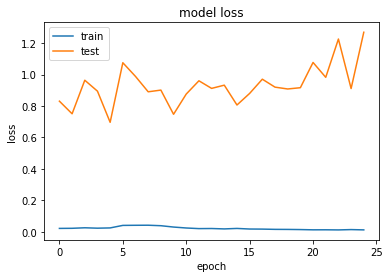

In [14]:
 plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [15]:
y_pred = model.predict_classes(X_test_pad)
confusion_matrix(y_pred ,y_test)

array([[110,  35],
       [ 79, 293]], dtype=int64)

In [10]:
def getModelError(y_pred, y_test, X_test):
    X_test_list = X_test.tolist()
    falsePositiveSentence = []
    falseNegativeSentence = []
    for i in range(0,len(y_pred)):
        if y_test[i] == 1 and y_pred[i] == 0:
            falsePositiveSentence.append(X_test_list[i])
        elif y_test[i] == 0 and y_pred[i] == 1:
            falseNegativeSentence.append(X_test_list[i])
    return (falsePositiveSentence, falseNegativeSentence)

In [11]:
falsePositive, falseNegative = getModelError(y_pred, y_test, X_test)

In [12]:
falsePositive

['watch $TSLA > 34.5 ',
 'Eli Lilly & Co. (LLY) Has Broken Out To A New High On AstraZeneca Collaboration',
 'UK MORNING BRIEFING: Sky And Hargreaves Lansdown Bookend FTSE 100',
 "Britain's FTSE steadies below record high, BHP gains",
 'lets see 14+ today ',
 'short didnt work out ',
 '$FCX +3.53% ',
 'ses warrants to buy $1.17B & 14.97% of AmerisourceBergen(PBR16) shares ',
 'Institutions seem to like this class of stocks ',
 'CompaniesUnilever sales lifted by ice cream in soft economy',
 'hanging tough in down market due to analyst upgrades Up almost 3% ',
 'magically bought at under a dollar ',
 'starting to show some relative strength ',
 'FTSE 100 movers: BG Group leads the charge as resource stocks jump',
 'European shares fall on Chinese import data, SABMiller soars',
 "ITV strike: Broadcaster's revenue soars but staff walkout for a piece of the action",
 '$SPY up only 0.6% Still holding ',
 'UPDATE: CIB, Legal & General Sell Egyptian Life Joint Venture To AXA',
 '$CAFN Cachet F